In [36]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
import tidy3d.web as web
from dask.array import shape
from dask.sizeof import sizeof

# --- 1. Material Definitions ---
# Using fixed indices for 1550nm for simplicity

wavelength =  1.55                              # Central wavelength
wv_points = 50                   # number of wavelength wv_points
pos_points = 15
width = 0.35
n_si = 3.475
n_sio2 = 1.458
gap_points = 5

sweep_wavelength = np.linspace(1.5,1.6,wv_points)  # Sweep on wavelengths
sweep_freq = td.C_0 / sweep_wavelength          # Sweep on Frequencies
bandwidth = sweep_wavelength[-1]-sweep_wavelength[0]
sweep_monitor_pos = np.linspace(-6,6,pos_points)
sweep_gap = np.linspace(0.15,0.25,gap_points)

mat_si = td.material_library["cSi"]["Li1993_293K"] # Material trace permitivity model for crystaline Silicon
mat_sio2 = td.material_library["SiO2"]["Horiba"]   # Material trace permitivity model for crystaline Silica


web.configure("U7IS5Q1AW3qYVxPAAQDE7vgxaTz6Kt6aI9AioPZUajVRQQ2o")

Configuration saved successfully.


In [51]:


def build_slot_simulation(
    gap=np.array([0.15]),
    width=0.350,
    thickness=np.array([0.22,0.3]),
    wavelength = np.array([1.55]),
):

    # Frequency
    freq = td.C_0 / wavelength

    # Materials
    core = mat_si
    clad = mat_sio2

    # --- We define the simulation data array and simulation objects for the two different sweeps----

    sim_data_arr = [[],[]] # Simulation data for 220nm and 300nm
    sim_arr = [[],[]]      # Simulation objects for 220nm and 300nm
    estimate = 0

    #--- Define Sources ---
    freq0 = td.C_0 / wavelength.mean()
    fwidth = (td.C_0 / wavelength.min()) - (td.C_0 / wavelength.max())


    for thick_idx,thick in enumerate(thickness):
        for gap_idx,gap_values in enumerate(gap):

            # --- Define two silicon rails ---
            rail_offset = width/2 + gap_values/2


            rail_right = td.Structure(
                geometry=td.Box(
                    center=(0, rail_offset, 0),
                    size =(td.inf, width, thick),
                ),
                medium=core,
            )

            rail_left = td.Structure(
                geometry=td.Box(
                    center=(0, -rail_offset, 0),
                    size=(td.inf, width, thick),
                ),
                medium=core,
            ) # Bien definido hasta aca


            source1 = td.ModeSource(
            name = "Mode_source",
            center = [-7.5, rail_offset, 0],
            size = [0, width + gap_values / 2, thick + 0.5],
            source_time = td.GaussianPulse(freq0 = freq0, fwidth =fwidth,),
            direction = '+',
            mode_index=0,
            mode_spec= td.ModeSpec(num_modes=5,target_neff=n_si),
            )


            # --- Define monitors ---

            Through = td.FieldMonitor(
            name="Through",
            center = [2, rail_offset,0],
            size = [0, width + gap_values / 2, thick + 0.5],
            freqs = freq,
            )

            Cross = td.FieldMonitor(
            name="Cross",
            center = [2, -rail_offset, 0],
            size = [0, width + gap_values / 2, thick + 0.5],
            freqs = freq,
            )


            Both = td.FieldMonitor(
            name="Both",
            center = [2,0,0],
            size = [0, 2, 2],
            freqs = freq,
            )

            Longitudinal = td.FieldMonitor(
                name="Longitudinal",
                size = [td.inf, 7.75, 0],
                freqs = freq,
            )# Bien hasta aca

            # --- Simulation domain ---
            sim_arr[thick_idx].append(td.Simulation(
                size=(15.5, 15.5, 15.5),  # x ignored for mode solver
                monitors=[Cross,Through,Longitudinal,Both],
                sources=[source1],
                structures=[rail_right, rail_left],
                medium=clad,
                symmetry=(0, 0, 1),  # symmetry in z
                run_time=1e-12,
                grid_spec=td.GridSpec.auto(wavelength = wavelength.min(),min_steps_per_wvl = 11),
            ))



            Job = web.Job(simulation=sim_arr[thick_idx][gap_idx], task_name="my_sim")

            estimate+= Job.estimate_cost()

            sim_data_arr[thick_idx].append(web.run(sim_arr[thick_idx][gap_idx], task_name='DC_FDTD'))
    print(f"Estimated Maximum Cost: {estimate}")

    return sim_data_arr, sim_arr


sim_data, sim = build_slot_simulation(gap = sweep_gap,wavelength=sweep_wavelength)



15:25:43 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-45786c0d-7101-4914-bc25-fcb84b0658
                                        2e' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=91798;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45786c0d-7101-4914-bc25-fcb84b06582e\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=91798;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45786c0d-7101-4914-bc25-fcb84b06582e\ch?]8;;\]8;id=119096;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45786c0d-7101-4914-bc25-fcb84b06582e\taskId]8;;\]8;id=91798;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45786c0d-7101-4914-bc25-fcb84b06582e\=]8;;\]8;id=377718;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45786c0d-7101-4914-bc25-fcb84b06582e\fdve]8;;\]8;id=91798;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45786c0d-7101-4914-bc25-fcb84b06582e\-45786c0d-7101-4914-bc25-f]8;;\
                                        ]8;id=91798;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45786c0d-7101-4914-bc25-fcb84b06582e\cb84b06582e']8;;\.

                                        Task folder: ]8;id=181614;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

15:25:47 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.067.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-d142f4ae-a75c-4fcb-804f-8d7dd02e3e
                                        7f' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=883882;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d142f4ae-a75c-4fcb-804f-8d7dd02e3e7f\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=883882;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d142f4ae-a75c-4fcb-804f-8d7dd02e3e7f\ch?]8;;\]8;id=7802;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d142f4ae-a75c-4fcb-804f-8d7dd02e3e7f\taskId]8;;\]8;id=883882;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d142f4ae-a75c-4fcb-804f-8d7dd02e3e7f\=]8;;\]8;id=683568;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d142f4ae-a75c-4fcb-804f-8d7dd02e3e7f\fdve]8;;\]8;id=883882;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d142f4ae-a75c-4fcb-804f-8d7dd02e3e7f\-d142f4ae-a75c-4fcb-804f-8]8;;\
                                        ]8;id=883882;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d142f4ae-a75c-4fcb-804f-8d7dd02e3e7f\d7dd02e3e7f']8;;\.

                                        Task folder: ]8;id=545684;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

15:25:50 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.067.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

15:25:51 Hora est. Pacífico, Sudamérica status = success

15:25:58 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        Created task 'my_sim' with resource_id  
                                        'fdve-ca7f93db-2316-44e6-9955-0bfad185a5
                                        3f' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=681279;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ca7f93db-2316-44e6-9955-0bfad185a53f\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=681279;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ca7f93db-2316-44e6-9955-0bfad185a53f\ch?]8;;\]8;id=748755;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ca7f93db-2316-44e6-9955-0bfad185a53f\taskId]8;;\]8;id=681279;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ca7f93db-2316-44e6-9955-0bfad185a53f\=]8;;\]8;id=121686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ca7f93db-2316-44e6-9955-0bfad185a53f\fdve]8;;\]8;id=681279;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ca7f93db-2316-44e6-9955-0bfad185a53f\-ca7f93db-2316-44e6-9955-0]8;;\
                                        ]8;id=681279;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ca7f93db-2316-44e6-9955-0bfad185a53f\bfad185a53f']8;;\.

                                        Task folder: ]8;id=781760;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

15:26:01 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.069.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-97ab1c06-c183-425c-9e5c-27956ddfb0
                                        c3' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=448360;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97ab1c06-c183-425c-9e5c-27956ddfb0c3\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=448360;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97ab1c06-c183-425c-9e5c-27956ddfb0c3\ch?]8;;\]8;id=120635;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97ab1c06-c183-425c-9e5c-27956ddfb0c3\taskId]8;;\]8;id=448360;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97ab1c06-c183-425c-9e5c-27956ddfb0c3\=]8;;\]8;id=507676;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97ab1c06-c183-425c-9e5c-27956ddfb0c3\fdve]8;;\]8;id=448360;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97ab1c06-c183-425c-9e5c-27956ddfb0c3\-97ab1c06-c183-425c-9e5c-2]8;;\
                                        ]8;id=448360;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97ab1c06-c183-425c-9e5c-27956ddfb0c3\7956ddfb0c3']8;;\.

                                        Task folder: ]8;id=922777;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

15:26:04 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.069.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

15:26:05 Hora est. Pacífico, Sudamérica status = success

15:26:20 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

15:26:21 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-18a27fa5-91ee-4ae7-a29f-64fbdcaf86
                                        ab' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=633952;https://tidy3d.simulation.cloud/workbench?taskId=fdve-18a27fa5-91ee-4ae7-a29f-64fbdcaf86ab\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=633952;https://tidy3d.simulation.cloud/workbench?taskId=fdve-18a27fa5-91ee-4ae7-a29f-64fbdcaf86ab\ch?]8;;\]8;id=656022;https://tidy3d.simulation.cloud/workbench?taskId=fdve-18a27fa5-91ee-4ae7-a29f-64fbdcaf86ab\taskId]8;;\]8;id=633952;https://tidy3d.simulation.cloud/workbench?taskId=fdve-18a27fa5-91ee-4ae7-a29f-64fbdcaf86ab\=]8;;\]8;id=480919;https://tidy3d.simulation.cloud/workbench?taskId=fdve-18a27fa5-91ee-4ae7-a29f-64fbdcaf86ab\fdve]8;;\]8;id=633952;https://tidy3d.simulation.cloud/workbench?taskId=fdve-18a27fa5-91ee-4ae7-a29f-64fbdcaf86ab\-18a27fa5-91ee-4ae7-a29f-6]8;;\
                                        ]8;id=633952;https://tidy3d.simulation.cloud/workbench?taskId=fdve-18a27fa5-91ee-4ae7-a29f-64fbdcaf86ab\4fbdcaf86ab']8;;\.

                                        Task folder: ]8;id=760438;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

15:26:24 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.070.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-a2236e1c-ad50-44a3-9c05-e3a731dbff
                                        7f' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=986301;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a2236e1c-ad50-44a3-9c05-e3a731dbff7f\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=986301;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a2236e1c-ad50-44a3-9c05-e3a731dbff7f\ch?]8;;\]8;id=166516;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a2236e1c-ad50-44a3-9c05-e3a731dbff7f\taskId]8;;\]8;id=986301;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a2236e1c-ad50-44a3-9c05-e3a731dbff7f\=]8;;\]8;id=479127;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a2236e1c-ad50-44a3-9c05-e3a731dbff7f\fdve]8;;\]8;id=986301;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a2236e1c-ad50-44a3-9c05-e3a731dbff7f\-a2236e1c-ad50-44a3-9c05-e]8;;\
                                        ]8;id=986301;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a2236e1c-ad50-44a3-9c05-e3a731dbff7f\3a731dbff7f']8;;\.

                                        Task folder: ]8;id=303549;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

15:26:26 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.070.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

15:26:28 Hora est. Pacífico, Sudamérica status = success

15:26:43 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        Created task 'my_sim' with resource_id  
                                        'fdve-5264f549-71c2-4340-8541-d587d2dfce
                                        55' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=736251;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5264f549-71c2-4340-8541-d587d2dfce55\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=736251;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5264f549-71c2-4340-8541-d587d2dfce55\ch?]8;;\]8;id=278214;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5264f549-71c2-4340-8541-d587d2dfce55\taskId]8;;\]8;id=736251;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5264f549-71c2-4340-8541-d587d2dfce55\=]8;;\]8;id=6443;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5264f549-71c2-4340-8541-d587d2dfce55\fdve]8;;\]8;id=736251;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5264f549-71c2-4340-8541-d587d2dfce55\-5264f549-71c2-4340-8541-d]8;;\
                                        ]8;id=736251;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5264f549-71c2-4340-8541-d587d2dfce55\587d2dfce55']8;;\.

                                        Task folder: ]8;id=985980;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

15:26:46 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.067.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

15:26:47 Hora est. Pacífico, Sudamérica Created task 'DC_FDTD' with resource_id 
                                        'fdve-1283db06-2da8-4057-9b68-92db838a31
                                        71' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=274572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1283db06-2da8-4057-9b68-92db838a3171\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=274572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1283db06-2da8-4057-9b68-92db838a3171\ch?]8;;\]8;id=59968;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1283db06-2da8-4057-9b68-92db838a3171\taskId]8;;\]8;id=274572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1283db06-2da8-4057-9b68-92db838a3171\=]8;;\]8;id=480428;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1283db06-2da8-4057-9b68-92db838a3171\fdve]8;;\]8;id=274572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1283db06-2da8-4057-9b68-92db838a3171\-1283db06-2da8-4057-9b68-9]8;;\
                                        ]8;id=274572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1283db06-2da8-4057-9b68-92db838a3171\2db838a3171']8;;\.

                                        Task folder: ]8;id=884354;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

15:26:49 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.067.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

15:26:50 Hora est. Pacífico, Sudamérica status = success

15:27:04 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

15:27:05 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-90ead263-ac10-45e8-9b0b-9360eece62
                                        4a' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=747338;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90ead263-ac10-45e8-9b0b-9360eece624a\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=747338;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90ead263-ac10-45e8-9b0b-9360eece624a\ch?]8;;\]8;id=385178;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90ead263-ac10-45e8-9b0b-9360eece624a\taskId]8;;\]8;id=747338;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90ead263-ac10-45e8-9b0b-9360eece624a\=]8;;\]8;id=616895;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90ead263-ac10-45e8-9b0b-9360eece624a\fdve]8;;\]8;id=747338;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90ead263-ac10-45e8-9b0b-9360eece624a\-90ead263-ac10-45e8-9b0b-9]8;;\
                                        ]8;id=747338;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90ead263-ac10-45e8-9b0b-9360eece624a\360eece624a']8;;\.

                                        Task folder: ]8;id=787780;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

15:27:08 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.069.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-91e375d4-9b73-423d-8198-0f60294594
                                        ab' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=873350;https://tidy3d.simulation.cloud/workbench?taskId=fdve-91e375d4-9b73-423d-8198-0f60294594ab\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=873350;https://tidy3d.simulation.cloud/workbench?taskId=fdve-91e375d4-9b73-423d-8198-0f60294594ab\ch?]8;;\]8;id=499403;https://tidy3d.simulation.cloud/workbench?taskId=fdve-91e375d4-9b73-423d-8198-0f60294594ab\taskId]8;;\]8;id=873350;https://tidy3d.simulation.cloud/workbench?taskId=fdve-91e375d4-9b73-423d-8198-0f60294594ab\=]8;;\]8;id=625977;https://tidy3d.simulation.cloud/workbench?taskId=fdve-91e375d4-9b73-423d-8198-0f60294594ab\fdve]8;;\]8;id=873350;https://tidy3d.simulation.cloud/workbench?taskId=fdve-91e375d4-9b73-423d-8198-0f60294594ab\-91e375d4-9b73-423d-8198-0]8;;\
                                        ]8;id=873350;https://tidy3d.simulation.cloud/workbench?taskId=fdve-91e375d4-9b73-423d-8198-0f60294594ab\f60294594ab']8;;\.

                                        Task folder: ]8;id=729283;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

15:27:10 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.069.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

15:27:12 Hora est. Pacífico, Sudamérica status = success

15:27:21 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        Created task 'my_sim' with resource_id  
                                        'fdve-dd51595f-6d8f-45d6-8d6a-8e09174864
                                        23' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=62786;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dd51595f-6d8f-45d6-8d6a-8e0917486423\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=62786;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dd51595f-6d8f-45d6-8d6a-8e0917486423\ch?]8;;\]8;id=40318;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dd51595f-6d8f-45d6-8d6a-8e0917486423\taskId]8;;\]8;id=62786;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dd51595f-6d8f-45d6-8d6a-8e0917486423\=]8;;\]8;id=399054;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dd51595f-6d8f-45d6-8d6a-8e0917486423\fdve]8;;\]8;id=62786;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dd51595f-6d8f-45d6-8d6a-8e0917486423\-dd51595f-6d8f-45d6-8d6a-8]8;;\
                                        ]8;id=62786;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dd51595f-6d8f-45d6-8d6a-8e0917486423\e0917486423']8;;\.

                                        Task folder: ]8;id=857300;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

15:27:24 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.067.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

15:27:25 Hora est. Pacífico, Sudamérica Created task 'DC_FDTD' with resource_id 
                                        'fdve-9d941d65-8e3d-4958-8d23-2cfcf6cb08
                                        f8' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=622130;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d941d65-8e3d-4958-8d23-2cfcf6cb08f8\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=622130;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d941d65-8e3d-4958-8d23-2cfcf6cb08f8\ch?]8;;\]8;id=460488;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d941d65-8e3d-4958-8d23-2cfcf6cb08f8\taskId]8;;\]8;id=622130;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d941d65-8e3d-4958-8d23-2cfcf6cb08f8\=]8;;\]8;id=142497;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d941d65-8e3d-4958-8d23-2cfcf6cb08f8\fdve]8;;\]8;id=622130;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d941d65-8e3d-4958-8d23-2cfcf6cb08f8\-9d941d65-8e3d-4958-8d23-2]8;;\
                                        ]8;id=622130;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d941d65-8e3d-4958-8d23-2cfcf6cb08f8\cfcf6cb08f8']8;;\.

                                        Task folder: ]8;id=4951;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

15:27:27 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.067.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

15:27:29 Hora est. Pacífico, Sudamérica status = success

15:27:38 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        Created task 'my_sim' with resource_id  
                                        'fdve-39379e2e-0917-4734-a811-b125ca0931
                                        ff' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=843870;https://tidy3d.simulation.cloud/workbench?taskId=fdve-39379e2e-0917-4734-a811-b125ca0931ff\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=843870;https://tidy3d.simulation.cloud/workbench?taskId=fdve-39379e2e-0917-4734-a811-b125ca0931ff\ch?]8;;\]8;id=278375;https://tidy3d.simulation.cloud/workbench?taskId=fdve-39379e2e-0917-4734-a811-b125ca0931ff\taskId]8;;\]8;id=843870;https://tidy3d.simulation.cloud/workbench?taskId=fdve-39379e2e-0917-4734-a811-b125ca0931ff\=]8;;\]8;id=708574;https://tidy3d.simulation.cloud/workbench?taskId=fdve-39379e2e-0917-4734-a811-b125ca0931ff\fdve]8;;\]8;id=843870;https://tidy3d.simulation.cloud/workbench?taskId=fdve-39379e2e-0917-4734-a811-b125ca0931ff\-39379e2e-0917-4734-a811-b]8;;\
                                        ]8;id=843870;https://tidy3d.simulation.cloud/workbench?taskId=fdve-39379e2e-0917-4734-a811-b125ca0931ff\125ca0931ff']8;;\.

                                        Task folder: ]8;id=90553;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

15:27:41 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.069.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

15:27:42 Hora est. Pacífico, Sudamérica Created task 'DC_FDTD' with resource_id 
                                        'fdve-68d002e1-6031-4e40-bdb2-3399348527
                                        d7' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=529782;https://tidy3d.simulation.cloud/workbench?taskId=fdve-68d002e1-6031-4e40-bdb2-3399348527d7\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=529782;https://tidy3d.simulation.cloud/workbench?taskId=fdve-68d002e1-6031-4e40-bdb2-3399348527d7\ch?]8;;\]8;id=511922;https://tidy3d.simulation.cloud/workbench?taskId=fdve-68d002e1-6031-4e40-bdb2-3399348527d7\taskId]8;;\]8;id=529782;https://tidy3d.simulation.cloud/workbench?taskId=fdve-68d002e1-6031-4e40-bdb2-3399348527d7\=]8;;\]8;id=72226;https://tidy3d.simulation.cloud/workbench?taskId=fdve-68d002e1-6031-4e40-bdb2-3399348527d7\fdve]8;;\]8;id=529782;https://tidy3d.simulation.cloud/workbench?taskId=fdve-68d002e1-6031-4e40-bdb2-3399348527d7\-68d002e1-6031-4e40-bdb2-3]8;;\
                                        ]8;id=529782;https://tidy3d.simulation.cloud/workbench?taskId=fdve-68d002e1-6031-4e40-bdb2-3399348527d7\399348527d7']8;;\.

                                        Task folder: ]8;id=64300;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

15:27:44 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.069.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

15:27:45 Hora est. Pacífico, Sudamérica status = success

15:27:53 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

15:27:54 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-a31ece77-64ac-4093-990c-bbad6c1504
                                        40' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=846745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a31ece77-64ac-4093-990c-bbad6c150440\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=846745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a31ece77-64ac-4093-990c-bbad6c150440\ch?]8;;\]8;id=797977;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a31ece77-64ac-4093-990c-bbad6c150440\taskId]8;;\]8;id=846745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a31ece77-64ac-4093-990c-bbad6c150440\=]8;;\]8;id=685963;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a31ece77-64ac-4093-990c-bbad6c150440\fdve]8;;\]8;id=846745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a31ece77-64ac-4093-990c-bbad6c150440\-a31ece77-64ac-4093-990c-b]8;;\
                                        ]8;id=846745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a31ece77-64ac-4093-990c-bbad6c150440\bad6c150440']8;;\.

                                        Task folder: ]8;id=920278;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

15:27:57 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.070.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-bfbcbccc-4a8d-4c38-a67f-c0f2f25953
                                        9d' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=56503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfbcbccc-4a8d-4c38-a67f-c0f2f259539d\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=56503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfbcbccc-4a8d-4c38-a67f-c0f2f259539d\ch?]8;;\]8;id=414181;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfbcbccc-4a8d-4c38-a67f-c0f2f259539d\taskId]8;;\]8;id=56503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfbcbccc-4a8d-4c38-a67f-c0f2f259539d\=]8;;\]8;id=306513;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfbcbccc-4a8d-4c38-a67f-c0f2f259539d\fdve]8;;\]8;id=56503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfbcbccc-4a8d-4c38-a67f-c0f2f259539d\-bfbcbccc-4a8d-4c38-a67f-c]8;;\
                                        ]8;id=56503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfbcbccc-4a8d-4c38-a67f-c0f2f259539d\0f2f259539d']8;;\.

                                        Task folder: ]8;id=201593;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

15:27:59 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.070.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

15:28:01 Hora est. Pacífico, Sudamérica status = success

15:28:16 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

15:28:17 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-b8d5cb31-8d4a-4fac-ac32-92e8a8080c
                                        2c' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=690209;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8d5cb31-8d4a-4fac-ac32-92e8a8080c2c\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=690209;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8d5cb31-8d4a-4fac-ac32-92e8a8080c2c\ch?]8;;\]8;id=420031;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8d5cb31-8d4a-4fac-ac32-92e8a8080c2c\taskId]8;;\]8;id=690209;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8d5cb31-8d4a-4fac-ac32-92e8a8080c2c\=]8;;\]8;id=131500;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8d5cb31-8d4a-4fac-ac32-92e8a8080c2c\fdve]8;;\]8;id=690209;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8d5cb31-8d4a-4fac-ac32-92e8a8080c2c\-b8d5cb31-8d4a-4fac-ac32-9]8;;\
                                        ]8;id=690209;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8d5cb31-8d4a-4fac-ac32-92e8a8080c2c\2e8a8080c2c']8;;\.

                                        Task folder: ]8;id=942313;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

15:28:20 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.067.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-a43f1e3a-6d05-47da-a1d4-4a916bbf7f
                                        a9' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=383304;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a43f1e3a-6d05-47da-a1d4-4a916bbf7fa9\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=383304;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a43f1e3a-6d05-47da-a1d4-4a916bbf7fa9\ch?]8;;\]8;id=178133;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a43f1e3a-6d05-47da-a1d4-4a916bbf7fa9\taskId]8;;\]8;id=383304;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a43f1e3a-6d05-47da-a1d4-4a916bbf7fa9\=]8;;\]8;id=609674;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a43f1e3a-6d05-47da-a1d4-4a916bbf7fa9\fdve]8;;\]8;id=383304;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a43f1e3a-6d05-47da-a1d4-4a916bbf7fa9\-a43f1e3a-6d05-47da-a1d4-4]8;;\
                                        ]8;id=383304;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a43f1e3a-6d05-47da-a1d4-4a916bbf7fa9\a916bbf7fa9']8;;\.

                                        Task folder: ]8;id=243895;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

15:28:23 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.067.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

15:28:24 Hora est. Pacífico, Sudamérica status = success

15:28:32 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

15:28:33 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-c7aaa282-7c48-4baf-a71d-fb0f2ee214
                                        9d' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=85137;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c7aaa282-7c48-4baf-a71d-fb0f2ee2149d\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=85137;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c7aaa282-7c48-4baf-a71d-fb0f2ee2149d\ch?]8;;\]8;id=2624;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c7aaa282-7c48-4baf-a71d-fb0f2ee2149d\taskId]8;;\]8;id=85137;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c7aaa282-7c48-4baf-a71d-fb0f2ee2149d\=]8;;\]8;id=725859;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c7aaa282-7c48-4baf-a71d-fb0f2ee2149d\fdve]8;;\]8;id=85137;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c7aaa282-7c48-4baf-a71d-fb0f2ee2149d\-c7aaa282-7c48-4baf-a71d-f]8;;\
                                        ]8;id=85137;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c7aaa282-7c48-4baf-a71d-fb0f2ee2149d\b0f2ee2149d']8;;\.

                                        Task folder: ]8;id=83812;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

15:28:36 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.069.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-e5a92673-7bd0-4f23-b826-5b5d5fad67
                                        5c' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=863330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5a92673-7bd0-4f23-b826-5b5d5fad675c\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=863330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5a92673-7bd0-4f23-b826-5b5d5fad675c\ch?]8;;\]8;id=245914;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5a92673-7bd0-4f23-b826-5b5d5fad675c\taskId]8;;\]8;id=863330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5a92673-7bd0-4f23-b826-5b5d5fad675c\=]8;;\]8;id=439560;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5a92673-7bd0-4f23-b826-5b5d5fad675c\fdve]8;;\]8;id=863330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5a92673-7bd0-4f23-b826-5b5d5fad675c\-e5a92673-7bd0-4f23-b826-5]8;;\
                                        ]8;id=863330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5a92673-7bd0-4f23-b826-5b5d5fad675c\b5d5fad675c']8;;\.

                                        Task folder: ]8;id=263361;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

15:28:38 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.069.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

15:28:40 Hora est. Pacífico, Sudamérica status = success

15:28:56 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

Estimated Maximum Cost: 0.685149659231005


## Results of the whole simulation

Next we are going to present the results from the simulation, firstly presenting the different platforms simulated.

Thickness of 220 nm and 300 nm

and a fixed with of 350 nm to asure single mode for each waveguide.


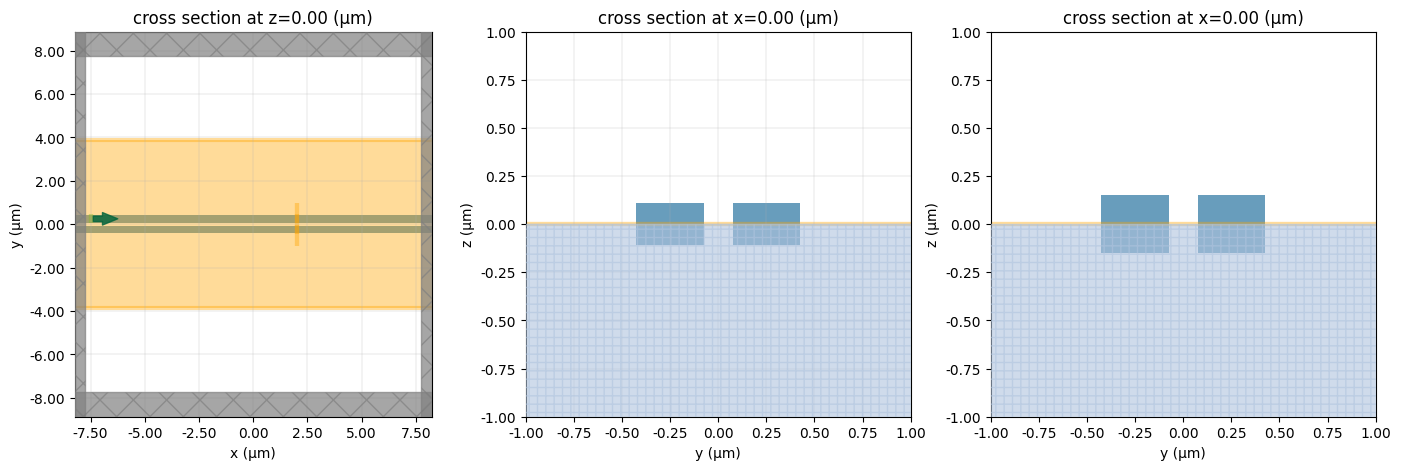

In [188]:
Cross, Through, Longitudinal, Both = [[],[]],[[],[]],[[],[]],[[],[]]

for thick_idx in range(2):
    for gap_idx in range(gap_points):
        Cross[thick_idx].append(sim_data[thick_idx][gap_idx]["Cross"])
        Through[thick_idx].append(sim_data[thick_idx][gap_idx]["Through"])
        Longitudinal[thick_idx].append(sim_data[thick_idx][gap_idx]["Longitudinal"])
        Both[thick_idx].append(sim_data[thick_idx][gap_idx]["Both"])



# A qcontinuacion vamos  a hacer los plots necesarios que pide la tarea,

"""
1. Muestra del Throuhgh Cross y Both , solo por mostrar para algunos casos de gap,(3) casos de gap los resultados para cada una de las estructuras 200 y 300  LISTO
2. Vamos a mostrar la seccion longitudinal del slot, mostrando el fenomeno de interferencia funcionando LISTO
3. Buscar como calcular El coupling ratio a partir del monitor Longitudinal. con esto sacar la curva de Coupling ratio Vs Length medido desde la posicion en la que se inserta la fuente

"""

#------- Primer reto ---------

fig0, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(17, 5))
sim[0][0].plot(z = 0, lw=1, ax=ax1)
sim[0][0].plot(x=0, lw=1, ax=ax2)
sim[1][0].plot(x=0, lw=1, ax=ax3)
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])

ax3.set_xlim([-1, 1])
ax3.set_ylim([-1, 1])


ax1.grid(True,linewidth = 0.2)
ax2.grid(True,linewidth = 0.2)
plt.show()





# Cross monitor power analysis for different gaps and platforms

The cross sectional waveguide (the one which the power splits in), we can appretiate for different gaps the cross section supermodes interferes diferently.

We can observe the thendency of longering the x-distribuited field by incresing the gap.

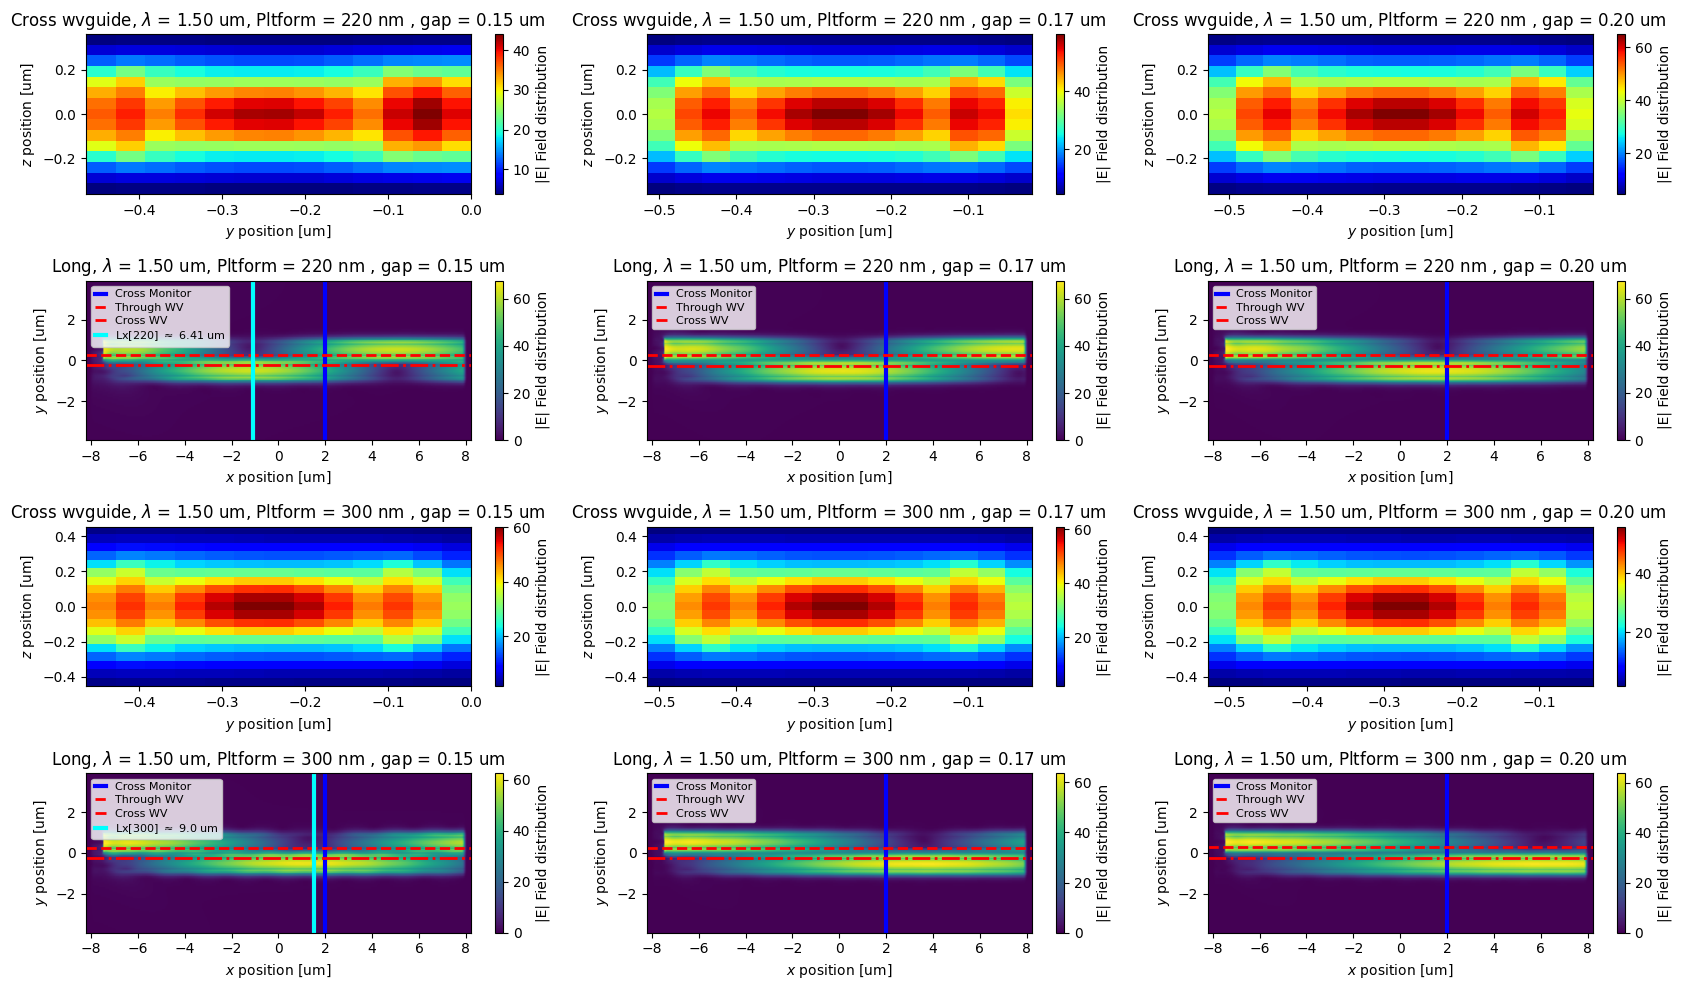

In [189]:
fig1, axes1 = plt.subplots(4, 3, figsize=(17, 10))

## Recorremos los repetorios de datos para el monitor cross y el monitor longitudinal y asi hallar la norma del campo electrico para cada plot.


wv_fix = 0
len_y = Longitudinal[0][0].Ex.abs.isel(f = wv_fix).squeeze().coords['y'].values

for thick_idx in range(2):
    for gap_idx in range(3):

        Ex_X = Cross[thick_idx][gap_idx].Ex.abs.isel(f = wv_fix).squeeze()
        Ey_X = Cross[thick_idx][gap_idx].Ey.abs.isel(f = wv_fix).squeeze()
        Ez_X = Cross[thick_idx][gap_idx].Ez.abs.isel(f = wv_fix).squeeze()
        E_X = np.sqrt(np.abs(Ex_X)**2 + np.abs(Ey_X)**2 + np.abs(Ez_X)**2)

        x_X = Ex_X.coords['y'].values
        y_X = Ex_X.coords['z'].values


        im = axes1[2*thick_idx][gap_idx].imshow(
                E_X.T,                     # transpose if needed
                extent=[x_X.min(), x_X.max(),
                        y_X.min(), y_X.max()],
                origin='lower',
                aspect='auto',
                cmap='jet',
        )

        axes1[2*thick_idx][gap_idx].set_title(fr"Cross wvguide, $\lambda$ = {td.C_0/sweep_freq[wv_fix]:.2f} um, Pltform = {[220,300][thick_idx]} nm , gap = {sweep_gap[gap_idx]:.2f} um ")
        axes1[2*thick_idx][gap_idx].set_xlabel(r"$y$ position [um]")
        axes1[2*thick_idx][gap_idx].set_ylabel(r"$z$ position [um]")
        plt.colorbar(im, ax=axes1[2*thick_idx][gap_idx]).set_label("|E| Field distribution")

        Ex_L = Longitudinal[thick_idx][gap_idx].Ex.abs.isel(f = wv_fix).squeeze()
        Ey_L = Longitudinal[thick_idx][gap_idx].Ey.abs.isel(f = wv_fix).squeeze()
        Ez_L = Longitudinal[thick_idx][gap_idx].Ez.abs.isel(f = wv_fix).squeeze()
        E_L = np.sqrt(np.abs(Ex_L)**2 + np.abs(Ey_L)**2 + np.abs(Ez_L)**2)

        x_L = Ex_L.coords['x'].values
        y_L = Ex_L.coords['y'].values

        im = axes1[2*thick_idx+1][gap_idx].imshow(
                E_L.T,                     # transpose if needed
                extent=[x_L.min(), x_L.max(),
                        y_L.min(), y_L.max()],
                origin='lower',
                aspect='auto'
        )
        axes1[2*thick_idx+1][gap_idx].plot(np.ones(len(y_L))*2,y_L, lw = 3 ,color = "blue", label = "Cross Monitor")
        axes1[2*thick_idx+1][gap_idx].plot(x_L,np.ones(len(x_L))*(width/2+sweep_gap[gap_idx]/2), color="red", linestyle= '--', lw = 2 , label = "Through WV")
        axes1[2*thick_idx+1][gap_idx].plot(x_L,-np.ones(len(x_L))*(width/2+sweep_gap[gap_idx]/2), color="red", linestyle= '-.', lw = 2 , label = "Cross WV")


        axes1[2*thick_idx+1][gap_idx].legend(loc = "upper left",fontsize=8,handlelength=1,borderpad=0.3,labelspacing=0.3)
        axes1[2*thick_idx+1][gap_idx].set_title(fr"Long, $\lambda$ = {td.C_0/sweep_freq[wv_fix]:.2f} um, Pltform = {[220,300][thick_idx]} nm , gap = {sweep_gap[gap_idx]:.2f} um")
        axes1[2*thick_idx+1][gap_idx].set_xlabel(r"$x$ position [um]")
        axes1[2*thick_idx+1][gap_idx].set_ylabel(r"$y$ position [um]")
        plt.colorbar(im, ax=axes1[2*thick_idx+1][gap_idx]).set_label("|E| Field distribution")

axes1[1][0].plot(np.ones(len(len_y))*(-1.09),len_y, lw = 3 ,color = "cyan", label = fr"Lx[220] $\approx$ {6.41} um")
axes1[3][0].plot(np.ones(len(len_y))*(1.5),len_y, lw = 3 ,color = "cyan", label = fr"Lx[300] $\approx$ {9.0} um")
axes1[1][0].legend(loc = "upper left",fontsize=8,handlelength=1,borderpad=0.3,labelspacing=0.3)
axes1[3][0].legend(loc = "upper left",fontsize=8,handlelength=1,borderpad=0.3,labelspacing=0.3)
plt.tight_layout()


###From above we aproximately measured the coupling length for 1500 nm input , 220 and 300 nm platforms with a width fixed of 350 nm, theoretically the coupling lengths for a DC with this characteristics are:

$$
L_{x[220]} \approx 6.499 [um] \,\,\, L_{x[300]} \approx 9.09 [um]
$$


Using a cursor we find out the coupling length for FDTD simulation as:

$$
L_{x[220]} \approx 6.41 [um] \,\,\, L_{x[300]} \approx 9.0 [um]
$$

Resulting on relative errors of:

$$
err_{x[220]} = 1.4 \% \,\,\, err_{x[300]} =  1 \%
$$

## ----------------------------------------------------------------------------------------------------------------------------------

### We do the same for Through waveguide

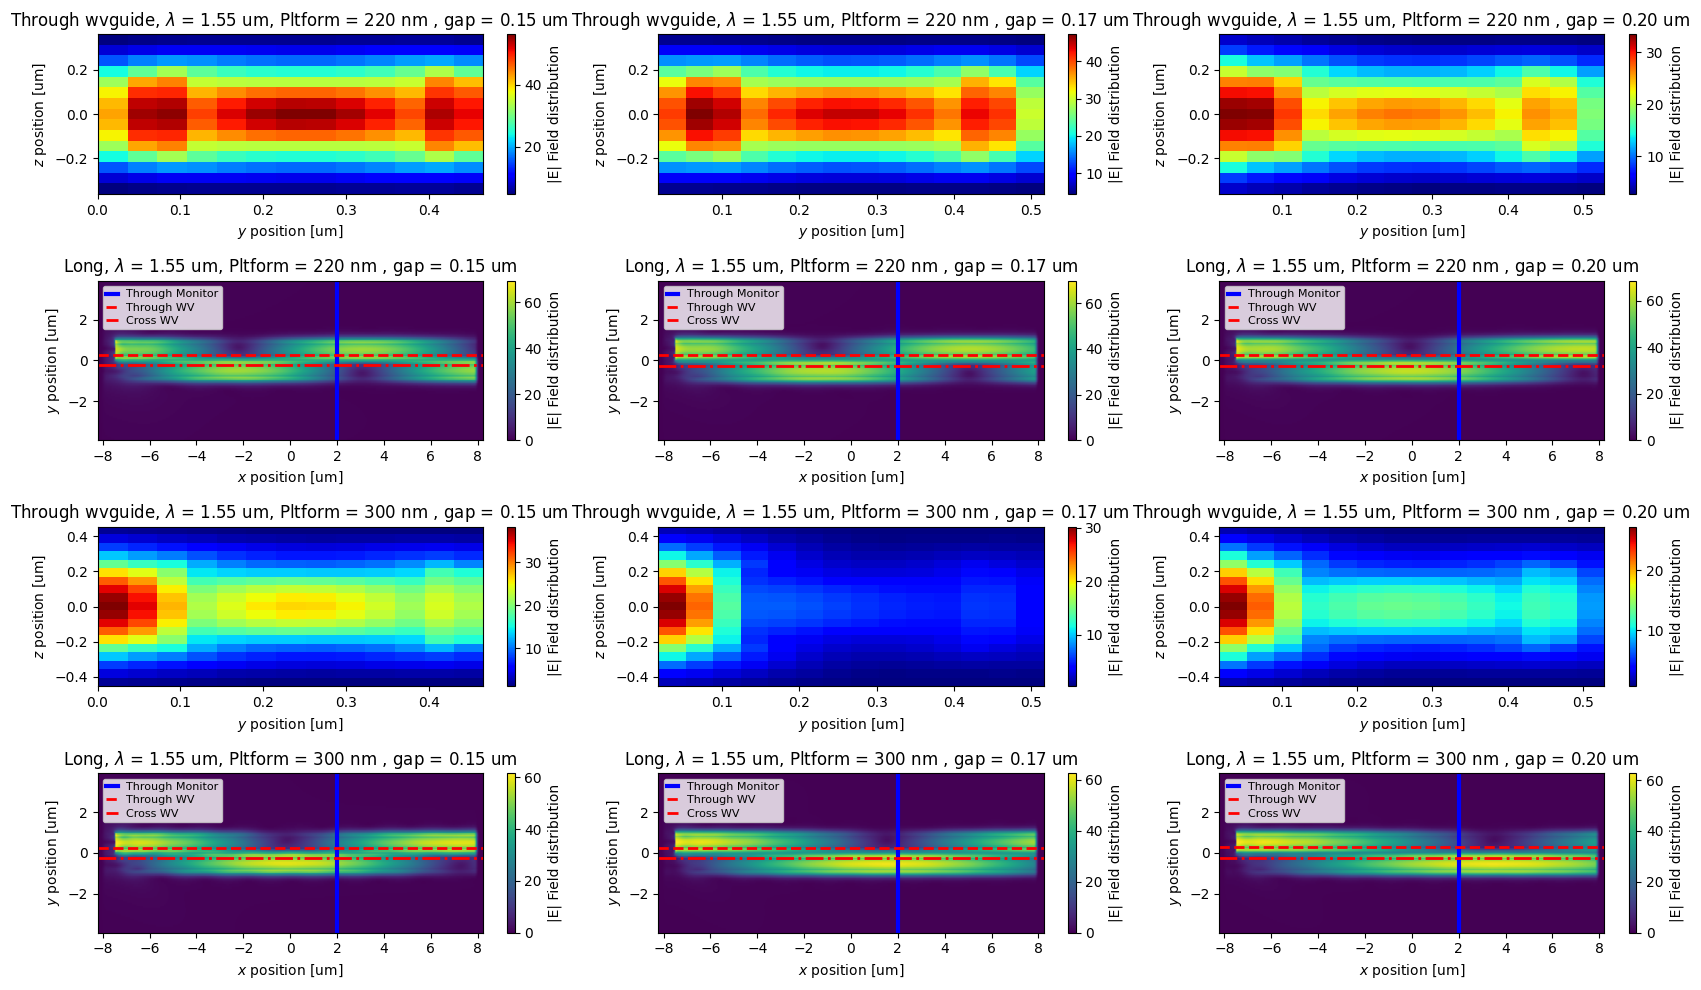

In [136]:
fig2, axe2 = plt.subplots(4, 3, figsize=(17, 10))

## Recorremos los repetorios de datos para el monitor cross y el monitor longitudinal y asi hallar la norma del campo electrico para cada plot.


for thick_idx in range(2):
    for gap_idx in range(3):

        Ex_T = Through[thick_idx][gap_idx].Ex.abs.isel(f = 24).squeeze()
        Ey_T = Through[thick_idx][gap_idx].Ey.abs.isel(f = 24).squeeze()
        Ez_T = Through[thick_idx][gap_idx].Ez.abs.isel(f = 24).squeeze()
        E_T = np.sqrt(np.abs(Ex_T)**2 + np.abs(Ey_T)**2 + np.abs(Ez_T)**2)

        x_T = Ex_T.coords['y'].values
        y_T = Ex_T.coords['z'].values


        im = axe2[2*thick_idx][gap_idx].imshow(
                E_T.T,                     # transpose if needed
                extent=[x_T.min(), x_T.max(),
                        y_T.min(), y_T.max()],
                origin='lower',
                aspect='auto',
                cmap='jet',
        )

        axe2[2*thick_idx][gap_idx].set_title(fr"Through wvguide, $\lambda$ = {td.C_0/sweep_freq[24]:.2f} um, Pltform = {[220,300][thick_idx]} nm , gap = {sweep_gap[gap_idx]:.2f} um ")
        axe2[2*thick_idx][gap_idx].set_xlabel(r"$y$ position [um]")
        axe2[2*thick_idx][gap_idx].set_ylabel(r"$z$ position [um]")
        plt.colorbar(im, ax=axe2[2*thick_idx][gap_idx]).set_label("|E| Field distribution")

        Ex_L = Longitudinal[thick_idx][gap_idx].Ex.abs.isel(f = 24).squeeze()
        Ey_L = Longitudinal[thick_idx][gap_idx].Ey.abs.isel(f = 24).squeeze()
        Ez_L = Longitudinal[thick_idx][gap_idx].Ez.abs.isel(f = 24).squeeze()
        E_L = np.sqrt(np.abs(Ex_L)**2 + np.abs(Ey_L)**2 + np.abs(Ez_L)**2)

        x_L = Ex_L.coords['x'].values
        y_L = Ex_L.coords['y'].values

        im = axe2[2*thick_idx+1][gap_idx].imshow(
                E_L.T,                     # transpose if needed
                extent=[x_L.min(), x_L.max(),
                        y_L.min(), y_L.max()],
                origin='lower',
                aspect='auto'
        )
        axe2[2*thick_idx+1][gap_idx].plot(np.ones(len(y_L))*2,y_L, lw = 3 ,color = "blue", label = "Through Monitor")
        axe2[2*thick_idx+1][gap_idx].plot(x_L,np.ones(len(x_L))*(width/2+sweep_gap[gap_idx]/2), color="red", linestyle= '--', lw = 2 , label = "Through WV")
        axe2[2*thick_idx+1][gap_idx].plot(x_L,-np.ones(len(x_L))*(width/2+sweep_gap[gap_idx]/2), color="red", linestyle= '-.', lw = 2 , label = "Cross WV")
        axe2[2*thick_idx+1][gap_idx].legend(loc = "upper left",fontsize=8,handlelength=1,borderpad=0.3,labelspacing=0.3)
        axe2[2*thick_idx+1][gap_idx].set_title(fr"Long, $\lambda$ = {td.C_0/sweep_freq[24]:.2f} um, Pltform = {[220,300][thick_idx]} nm , gap = {sweep_gap[gap_idx]:.2f} um")
        axe2[2*thick_idx+1][gap_idx].set_xlabel(r"$x$ position [um]")
        axe2[2*thick_idx+1][gap_idx].set_ylabel(r"$y$ position [um]")
        plt.colorbar(im, ax=axe2[2*thick_idx+1][gap_idx]).set_label("|E| Field distribution")

plt.tight_layout()


## Calculation of Coupling ratio

The coupling ratio is calculated (approximately) by calculating the transversal section of the real part of the complex poynting vector, towards the x directio (propagation):

$$
           P=\frac{1}{2} \int\int_{\infty } Re\{E\times H^{*} \}\cdot \hat{x} dA
$$

As an aproximation to the coupling ratio we will integrate over one dimention for this instance using the $Re\{ S_{x} \}$ and taking the integral to calculate the ratio:


$$
       \kappa^{2} \approx \frac{P_{cross}}{P_{0}} = \frac{\int^{0}_{-\infty } Re\{S_{x} \} dy}{\int^{\infty}_{-\infty } Re\{S_{x} \} dy}
$$


[-8.21969697e+00 -8.18055556e+00 -8.14141414e+00 -8.10227273e+00
 -8.06313131e+00 -8.02398990e+00 -7.98484848e+00 -7.94570707e+00
 -7.90656566e+00 -7.86742424e+00 -7.82828283e+00 -7.78914141e+00
 -7.75000000e+00 -7.71085859e+00 -7.67171717e+00 -7.63257576e+00
 -7.59343434e+00 -7.55429293e+00 -7.51515152e+00 -7.47601010e+00
 -7.43686869e+00 -7.39772727e+00 -7.35858586e+00 -7.31944444e+00
 -7.28030303e+00 -7.24116162e+00 -7.20202020e+00 -7.16287879e+00
 -7.12373737e+00 -7.08459596e+00 -7.04545455e+00 -7.00631313e+00
 -6.96717172e+00 -6.92803030e+00 -6.88888889e+00 -6.84974747e+00
 -6.81060606e+00 -6.77146465e+00 -6.73232323e+00 -6.69318182e+00
 -6.65404040e+00 -6.61489899e+00 -6.57575758e+00 -6.53661616e+00
 -6.49747475e+00 -6.45833333e+00 -6.41919192e+00 -6.38005051e+00
 -6.34090909e+00 -6.30176768e+00 -6.26262626e+00 -6.22348485e+00
 -6.18434343e+00 -6.14520202e+00 -6.10606061e+00 -6.06691919e+00
 -6.02777778e+00 -5.98863636e+00 -5.94949495e+00 -5.91035354e+00
 -5.87121212e+00 -5.83207

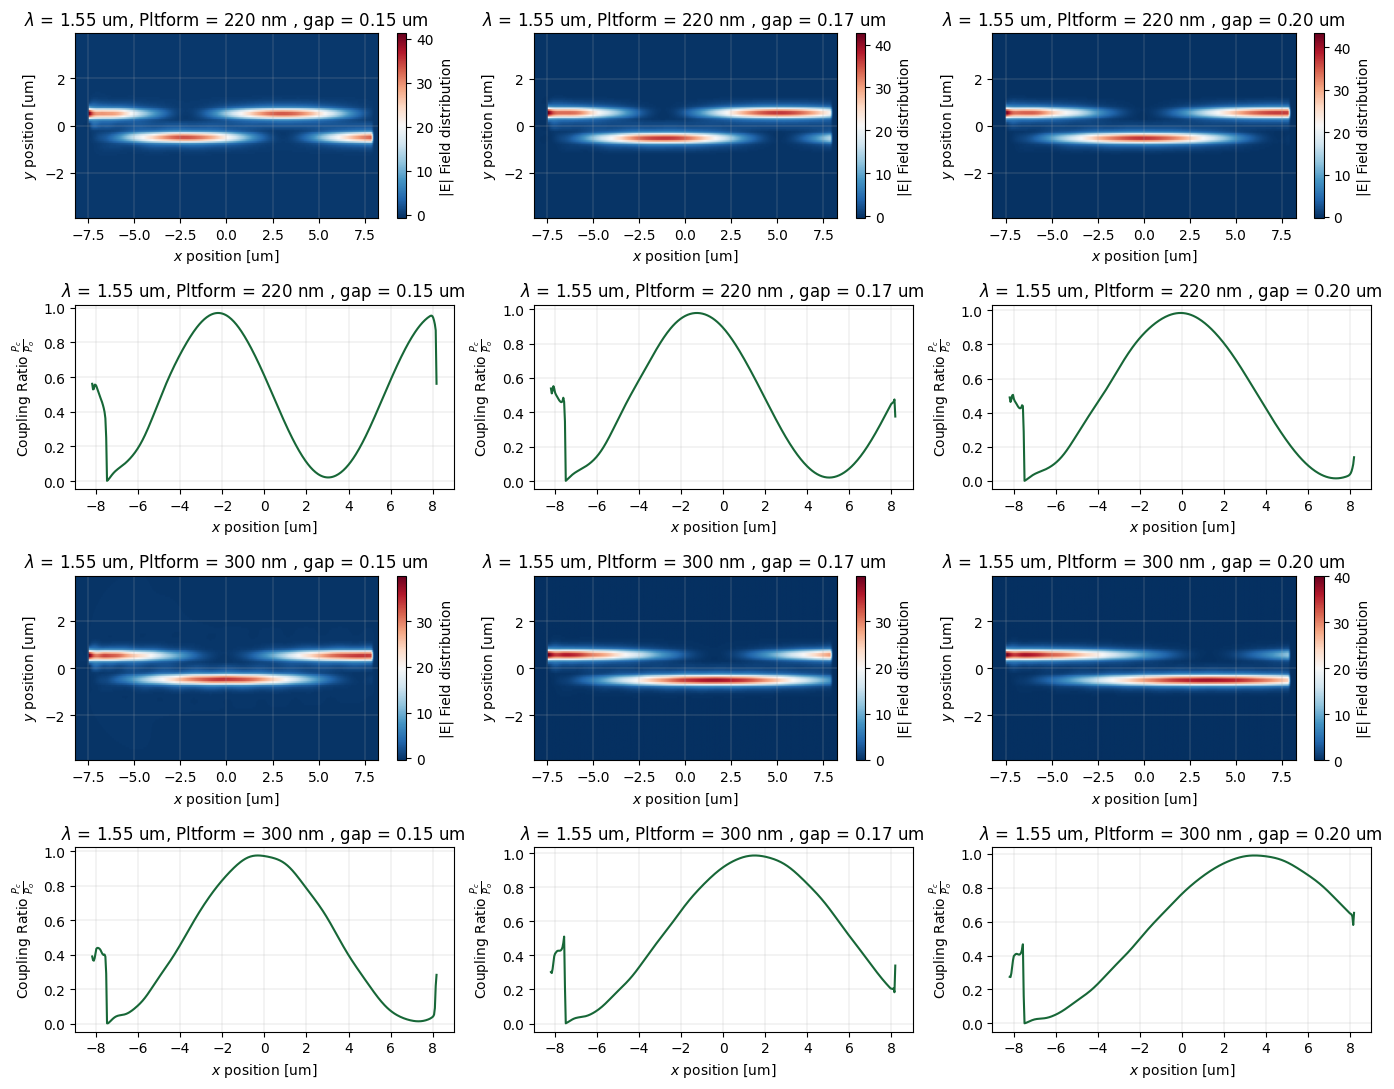

In [164]:
## We start by stracting the S_{x} data (the real part of it) , For that we calculate the x component of ExH*, (EyHz*-EzHy*)

fig3, axes3 = plt.subplots(4,3,figsize = (14,11))

for thick_idx in range(2):
    for gap_idx in range(3):

        Ey_LR = Longitudinal[thick_idx][gap_idx].Ey.real.isel(f = 24).squeeze() # La componente real Ey a 1550 nm
        Ez_LR = Longitudinal[thick_idx][gap_idx].Ez.real.isel(f = 24).squeeze() # La componente real Ez a 1550 nm

        Hy_LR = Longitudinal[thick_idx][gap_idx].Hy.real.isel(f = 24).squeeze() # La componente real Hy a 1550 nm
        Hz_LR = Longitudinal[thick_idx][gap_idx].Hz.real.isel(f = 24).squeeze() # La componente real Hz a 1550 nm


        Ey_LI = Longitudinal[thick_idx][gap_idx].Ey.imag.isel(f = 24).squeeze() # La componente Imaginaria Ey a 1550 nm
        Ez_LI = Longitudinal[thick_idx][gap_idx].Ez.imag.isel(f = 24).squeeze() # La componente Imaginaria Ez a 1550 nm

        Hy_LI = Longitudinal[thick_idx][gap_idx].Hy.imag.isel(f = 24).squeeze() # La componente Imaginaria Hy a 1550 nm
        Hz_LI = Longitudinal[thick_idx][gap_idx].Hz.imag.isel(f = 24).squeeze() # La componente Imaginaria Hz a 1550 nm


        Sx_LR =  Ey_LR*Hz_LR + Ey_LI*Hz_LI - (Ez_LR*Hy_LR + Ez_LI*Hy_LI) # Calculo de la parte real de la componente X del vector de poynting

        x_L = Ey_LR.coords['x'].values
        y_L = Ey_LR.coords['y'].values


        im = axes3[2*thick_idx][gap_idx].imshow(
                Sx_LR.T,                     # transpose if needed
                extent=[x_L.min(), x_L.max(),
                        y_L.min(), y_L.max()],
                origin='lower',
                aspect='auto',
                cmap='RdBu_r',
        )

        axes3[2*thick_idx][gap_idx].set_title(fr"$\lambda$ = {td.C_0/sweep_freq[24]:.2f} um, Pltform = "
                        fr"{[220,300][thick_idx]} nm , gap = {sweep_gap[gap_idx]:.2f} um ")
        axes3[2*thick_idx][gap_idx].set_xlabel(r"$x$ position [um]")
        axes3[2*thick_idx][gap_idx].set_ylabel(r"$y$ position [um]")
        plt.colorbar(im, ax=axes3[2*thick_idx][gap_idx]).set_label("Re[Sx] Field distribution")
        axes3[2*thick_idx][gap_idx].grid(True,linestyle='-', linewidth=0.2)

        print(x_L)

        #Results
        # x_idx_0 = np.abs(x_L - (-6.0)).argmin()
        # x_idx_f = np.abs(x_L - (6.0)).argmin()
        Coulpling_ratio = np.zeros(len(x_L))

        middle_y_dom = int(len(y_L)/2)
        for L in range(len(x_L)):

            P_cross = sum(np.abs(Sx_LR[L,0:middle_y_dom]))
            P_0 = sum(np.abs(Sx_LR[L,0:-1]))

            k = P_cross/P_0
            Coulpling_ratio[L] = k

        axes3[2*thick_idx+1][gap_idx].plot(x_L,Coulpling_ratio)

        axes3[2*thick_idx+1][gap_idx].set_title(fr"$\lambda$ = {td.C_0/sweep_freq[24]:.2f} um, Pltform = "
                        fr"{[220,300][thick_idx]} nm , gap = {sweep_gap[gap_idx]:.2f} um ")
        axes3[2*thick_idx+1][gap_idx].set_xlabel(r"$x$ position [um]")
        axes3[2*thick_idx+1][gap_idx].set_ylabel(r"Coupling Ratio $\frac{P_{c}}{P_{o}}$")
        axes3[2*thick_idx+1][gap_idx].grid(True,linestyle='-', linewidth=0.2)




plt.tight_layout()


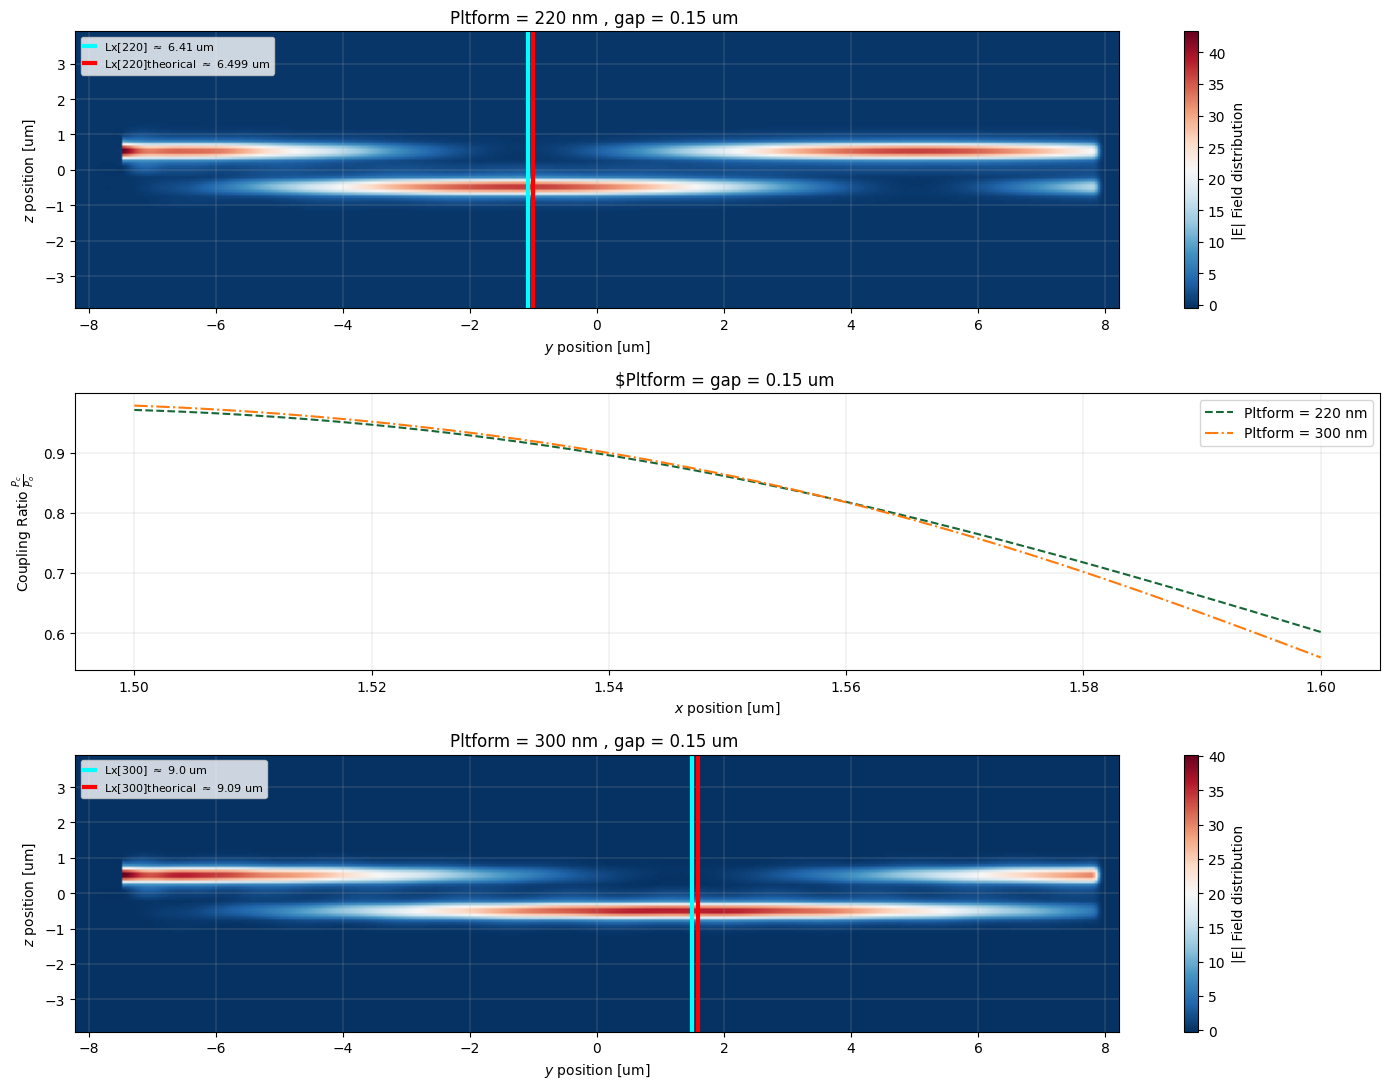

In [187]:
fig4, axes4 = plt.subplots(3,1,figsize = (14,11))

gap_fix = 0

x_L = Longitudinal[0][0].Ex.abs.isel(f = wv_fix).squeeze().coords['y'].values
y_L = Longitudinal[0][0].Ex.abs.isel(f = wv_fix).squeeze().coords['y'].values
Coulpling_ratio_220 = np.zeros(wv_points)
Coulpling_ratio_300 = np.zeros(wv_points)


Sx_MAPP  = 0
for thick_idx in range(2):

    for wvl_idx,wvl_value in enumerate(sweep_wavelength):
        Ey_LR = Longitudinal[thick_idx][gap_fix].Ey.real.isel(f = wvl_idx).squeeze() # La componente real Ey a 1550 nm
        Ez_LR = Longitudinal[thick_idx][gap_fix].Ez.real.isel(f = wvl_idx).squeeze() # La componente real Ez a 1550 nm

        Hy_LR = Longitudinal[thick_idx][gap_fix].Hy.real.isel(f = wvl_idx).squeeze() # La componente real Hy a 1550 nm
        Hz_LR = Longitudinal[thick_idx][gap_fix].Hz.real.isel(f = wvl_idx).squeeze() # La componente real Hz a 1550 nm


        Ey_LI = Longitudinal[thick_idx][gap_fix].Ey.imag.isel(f = wvl_idx).squeeze() # La componente Imaginaria Ey a 1550 nm
        Ez_LI = Longitudinal[thick_idx][gap_fix].Ez.imag.isel(f = wvl_idx).squeeze() # La componente Imaginaria Ez a 1550 nm

        Hy_LI = Longitudinal[thick_idx][gap_fix].Hy.imag.isel(f = wvl_idx).squeeze() # La componente Imaginaria Hy a 1550 nm
        Hz_LI = Longitudinal[thick_idx][gap_fix].Hz.imag.isel(f = wvl_idx).squeeze() # La componente Imaginaria Hz a 1550 nm


        Sx_LR =  Ey_LR*Hz_LR + Ey_LI*Hz_LI - (Ez_LR*Hy_LR + Ez_LI*Hy_LI) # Calculo de la parte real de la componente X del vector de poynting
        if wvl_idx == 0:
            Sx_MAPP = Sx_LR

        x_L = Ey_LR.coords['x'].values
        y_L = Ey_LR.coords['y'].values


        #Results

        x_meas220_idx = np.abs(x_L-(-1.09)).argmin()
        x_meas300_idx = np.abs(x_L-1.5).argmin()


        middle_y_dom = int(len(y_L)/2)

        P_cross_220 = sum(Sx_LR[x_meas220_idx,0:middle_y_dom])
        P_cross_300 = sum(Sx_LR[x_meas300_idx,0:middle_y_dom])

        P_0_220 = sum(Sx_LR[x_meas220_idx])
        P_0_300 = sum(Sx_LR[x_meas300_idx])


        k_220 = P_cross_220/P_0_220
        k_300 = P_cross_300/P_0_300

        Coulpling_ratio_220[wvl_idx] = k_220
        Coulpling_ratio_300[wvl_idx] = k_300



    im = axes4[2*thick_idx].imshow(
        Sx_MAPP.T,                     # transpose if needed
        extent=[x_L.min(), x_L.max(),
                y_L.min(), y_L.max()],
        origin='lower',
        aspect='auto',
        cmap='RdBu_r',
    )

    axes4[2*thick_idx].set_title(fr"Pltform = "
                    fr"{[220,300][thick_idx]} nm , gap = {sweep_gap[gap_fix]:.2f} um ")
    axes4[2*thick_idx].set_xlabel(r"$y$ position [um]")
    axes4[2*thick_idx].set_ylabel(r"$z$ position [um]")
    plt.colorbar(im,ax=axes4[2*thick_idx]).set_label("|E| Field distribution")
    axes4[2*thick_idx].grid(True,linestyle='-', linewidth=0.2)

    if thick_idx == 0 :
        axes4[1].plot(sweep_wavelength,Coulpling_ratio_220, label = fr"Pltform = {[220,300][thick_idx]} nm", linestyle = '--')
    else:
        axes4[1].plot(sweep_wavelength,Coulpling_ratio_300, label = fr"Pltform = {[220,300][thick_idx]} nm", linestyle = '-.')


axes4[1].set_title(fr"Pltform = "
                fr"gap = {sweep_gap[0]:.2f} um ")
axes4[1].set_xlabel(r"Wavelength $\lambda$ [um]")
axes4[1].set_ylabel(r"Coupling Ratio $\frac{P_{c}}{P_{o}}$")
axes4[1].grid(True,linestyle='-', linewidth=0.2)
axes4[1].legend()

axes4[0].plot(np.ones(len(y_L))*(-1.09),y_L, lw = 3 ,color = "cyan", label = fr"Lx[220] $\approx$ {6.41} um")
axes4[2].plot(np.ones(len(y_L))*(1.5),y_L, lw = 3 ,color = "cyan", label = fr"Lx[300] $\approx$ {9.0} um")
axes4[0].plot(np.ones(len(y_L))*(-1.001),y_L, lw = 3 ,color = "red", label = fr"Lx[220]theorical $\approx$ {6.499} um")
axes4[2].plot(np.ones(len(y_L))*(1.59),y_L, lw = 3 ,color = "red", label = fr"Lx[300]theorical $\approx$ {9.09} um")
axes4[0].legend(loc = "upper left",fontsize=8,handlelength=1,borderpad=0.3,labelspacing=0.3)
axes4[2].legend(loc = "upper left",fontsize=8,handlelength=1,borderpad=0.3,labelspacing=0.3)

plt.tight_layout()